Matplotlib is building the font cache; this may take a moment.


Text(0, 0.5, 'Left-Handedness Rate (%)')

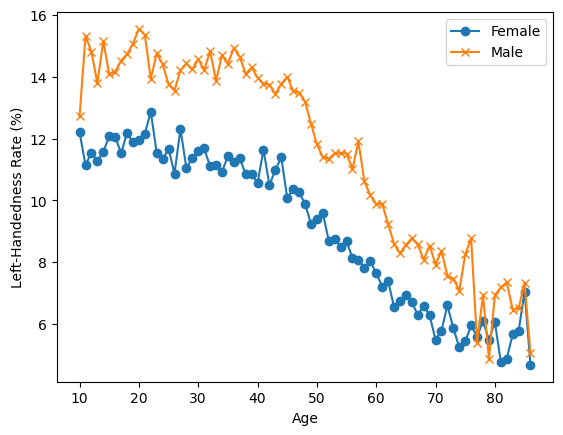

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt

# load the data
lefthanded_data = pd.read_csv("dataset1.csv")

# plot male and female left-handedness rates vs. age
%matplotlib inline
fig, ax = plt.subplots() # create figure and axis objects
ax.plot(lefthanded_data['Age'], lefthanded_data['Female'], label='Female', marker='o') # plot "Female" vs. "Age"
ax.plot(lefthanded_data['Age'], lefthanded_data['Male'], label='Male', marker='x') # plot "Male" vs. "Age"
ax.legend() # add a legend
ax.set_xlabel("Age")
ax.set_ylabel("Left-Handedness Rate (%)")


Text(0, 0.5, 'Mean Left-Handedness Rate (%)')

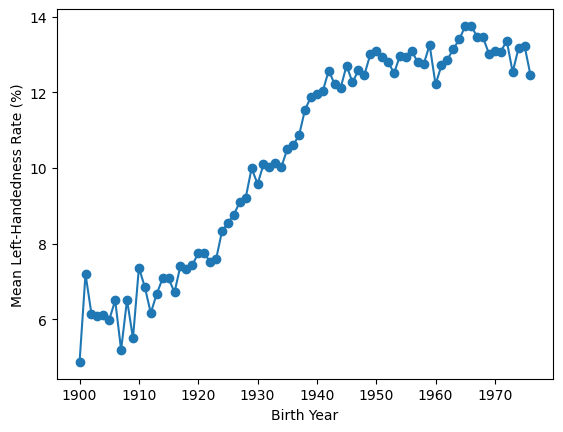

In [2]:
# create a new column for birth year of each age
lefthanded_data['Birth_year'] = 1986 - lefthanded_data['Age']

# create a new column for the average of male and female
lefthanded_data['Mean_lh'] = (lefthanded_data['Male'] + lefthanded_data['Female']) / 2

# create a plot of the 'Mean_lh' column vs. 'Birth_year'
fig, ax = plt.subplots()
ax.plot(lefthanded_data['Birth_year'], lefthanded_data['Mean_lh'], marker='o') # plot 'Mean_lh' vs. 'Birth_year'
ax.set_xlabel("Birth Year") # set the x label for the plot
ax.set_ylabel("Mean Left-Handedness Rate (%)") # set the y label for the plot


In [3]:
# import library
import numpy as np

# create a function for P(LH | A)
def P_lh_given_A(ages_of_death, study_year=1990):
    """ P(Left-handed | ages of death), calculated based on the reported rates of left-handedness.
    Inputs: numpy array of ages of death, study_year
    Returns: probability of left-handedness given that subjects died in `study_year` at ages `ages_of_death` """
    
    # Use the mean of the 10 last and 10 first points for left-handedness rates before and after the start 
    early_1900s_rate = lefthanded_data['Mean_lh'].iloc[-10:].mean()
    late_1900s_rate = lefthanded_data['Mean_lh'].iloc[:10].mean()
    
    middle_rates = lefthanded_data.loc[lefthanded_data['Birth_year'].isin(study_year - ages_of_death)]['Mean_lh']
    youngest_age = study_year - 1986 + 10  # the youngest age is 10
    oldest_age = study_year - 1986 + 86    # the oldest age is 86

    P_return = np.zeros(ages_of_death.shape)  # create an empty array to store the results
    
    # extract rate of left-handedness for people of ages 'ages_of_death'
    P_return[ages_of_death > oldest_age] = early_1900s_rate / 100
    P_return[ages_of_death < youngest_age] = late_1900s_rate / 100
    P_return[np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))] = middle_rates.values / 100
    
    return P_return


Text(0, 0.5, 'Number of Deaths')

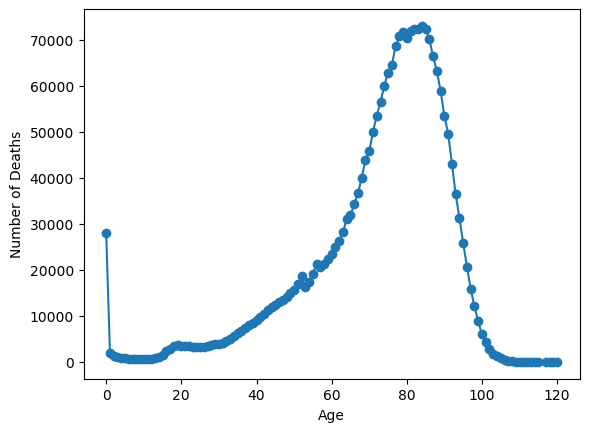

In [4]:
# Death distribution data for the United States in 1999
import pandas as pd
import matplotlib.pyplot as plt

# load death distribution data
death_distribution_data = pd.read_csv("dataset2.txt", sep='\t', skiprows=[1])

# drop NaN values from the `Both Sexes` column
death_distribution_data = death_distribution_data.dropna(subset=['Both Sexes'])

# plot number of people who died as a function of age
fig, ax = plt.subplots()
ax.plot('Age', 'Both Sexes', data=death_distribution_data, marker='o')  # plot 'Both Sexes' vs. 'Age'
ax.set_xlabel("Age")
ax.set_ylabel("Number of Deaths")


In [5]:
def P_lh(death_distribution_data, study_year = 1990): # sum over P_lh for each age group
    """ Overall probability of being left-handed if you died in the study year
    Input: dataframe of death distribution data, study year
    Output: P(LH), a single floating point number """
    ages = death_distribution_data['Age'].to_numpy()
    N_A = death_distribution_data['Both Sexes'].to_numpy()
    p_list = N_A * P_lh_given_A(ages, study_year)  # multiply number of dead people by P(LH | A)
    p = p_list.sum()  # sum all probabilities
    return p / N_A.sum()  # normalize by total deaths

print(P_lh(death_distribution_data))


0.07766387615350638


In [6]:
def P_A_given_lh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    total_deaths = death_distribution_data["Both Sexes"].sum()
    P_A = death_distribution_data["Both Sexes"] / total_deaths
    P_left = P_lh(death_distribution_data, study_year)  # uses Task 5 function
    P_lh_A = P_lh_given_A(ages_of_death, study_year)    # uses Task 3 function
    return P_lh_A * P_A / P_left


In [7]:
result = P_A_given_lh(death_distribution_data["Age"], death_distribution_data)
print(result.head())  # shows first few results


0    0.019694
1    0.001402
2    0.000970
3    0.000737
4    0.000591
Name: Both Sexes, dtype: float64


In [8]:
def P_A_given_rh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    # Total number of deaths
    total_deaths = death_distribution_data["Both Sexes"].sum()

    # P(A): Probability of dying at age A
    P_A = death_distribution_data["Both Sexes"] / total_deaths

    # P(LH): Overall probability of being left-handed (Task 5)
    P_left = P_lh(death_distribution_data, study_year)

    # P(RH): 1 - P(LH)
    P_right = 1 - P_left

    # P(LH | A): Task 3
    P_lh_A = P_lh_given_A(ages_of_death, study_year)

    # P(RH | A): 1 - P(LH | A)
    P_rh_A = 1 - P_lh_A

    # Bayes rule: P(A | RH) = P(RH | A) * P(A) / P(RH)
    return P_rh_A * P_A / P_right


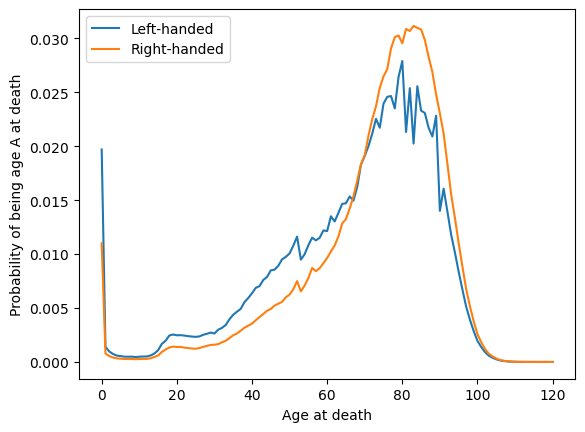

In [10]:
# Use actual ages from death_distribution_data
ages = death_distribution_data["Age"].values

# Calculate probabilities
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)

# Plotting the results
fig, ax = plt.subplots()
ax.plot(ages, left_handed_probability, label="Left-handed")
ax.plot(ages, right_handed_probability, label="Right-handed")
ax.legend()
ax.set_xlabel("Age at death")
ax.set_ylabel("Probability of being age A at death")
plt.show()



In [11]:
# Calculate average ages for left-handed and right-handed groups
average_lh_age = np.nansum(np.array(ages) * np.array(left_handed_probability))
average_rh_age = np.nansum(np.array(ages) * np.array(right_handed_probability))

# Print the average ages
print("Average age at death for left-handers: ", round(average_lh_age, 2), "years")
print("Average age at death for right-handers:", round(average_rh_age, 2), "years")

# Print the difference between the two
print("The difference in average ages is " + str(round(average_rh_age - average_lh_age, 2)) + " years.")


Average age at death for left-handers:  67.26 years
Average age at death for right-handers: 72.8 years
The difference in average ages is 5.54 years.


In [12]:
# Calculate the probability of being left- or right-handed for all ages in 2018
left_handed_probability_2018 = P_A_given_lh(ages, death_distribution_data, study_year=2018)
right_handed_probability_2018 = P_A_given_rh(ages, death_distribution_data, study_year=2018)

# Calculate average ages at death
average_lh_age_2018 = np.nansum(ages * np.array(left_handed_probability_2018))
average_rh_age_2018 = np.nansum(ages * np.array(right_handed_probability_2018))

# Print the result
print("Average age at death for left-handers in 2018:", round(average_lh_age_2018, 2), "years")
print("Average age at death for right-handers in 2018:", round(average_rh_age_2018, 2), "years")
print("The difference in average ages is " + 
      str(round(average_rh_age_2018 - average_lh_age_2018, 1)) + " years.")


Average age at death for left-handers in 2018: 70.3 years
Average age at death for right-handers in 2018: 72.64 years
The difference in average ages is 2.3 years.
